In [ ]:
import numpy as np
import pandas as pd
import plotly.express as px
import missingno as msno
import scipy.stats as stats
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, recall_score, accuracy_score, precision_score, f1_score
import pickle

In [ ]:
!pip install opendatasets
import opendatasets as od
od.download('https://www.kaggle.com/datasets/mykeysid10/covid19-dataset-for-year-2020/code?select=covid_data_2020-2021.csv')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gaurav065
Your Kaggle Key: ··········


100%|██████████| 8.02M/8.02M [00:00<00:00, 75.8MB/s]

In [ ]:
data = pd.read_csv("/content/covid19-dataset-for-year-2020/covid_data_2020-2021.csv")
data.head()

,test_date,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,test_indication
0,2021-10-11,0,0,0,0,0,Negative,Yes,female,Other
1,2021-10-11,0,0,0,0,0,Negative,Yes,male,Other
2,2021-10-11,0,0,0,0,0,Negative,No,female,Other
3,2021-10-11,0,0,0,0,0,Negative,Yes,female,Other
4,2021-10-11,0,0,0,0,0,Negative,Yes,female,Other


In [ ]:
data.info()

In [ ]:

def show(data):
  for i in data.columns[1:]:
    print("Feature: {} with {} Levels".format(i,data[i].unique()))

show(data)

Feature: cough with [0 1] Levels
Feature: fever with [0 1] Levels
Feature: sore_throat with [0 1] Levels
Feature: shortness_of_breath with [0 1] Levels
Feature: head_ache with [0 1] Levels
Feature: corona_result with ['Negative' 'Positive'] Levels
Feature: age_60_and_above with ['Yes' 'No'] Levels
Feature: gender with ['female' 'male'] Levels
Feature: test_indication with ['Other' 'Contact with confirmed' 'Abroad'] Levels


In [ ]:
data.isnull().sum()

test_date              0
cough                  0
fever                  0
sore_throat            0
shortness_of_breath    0
head_ache              0
corona_result          0
age_60_and_above       0
gender                 0
test_indication        0
dtype: int64

In [ ]:
# Label Encoding

data['corona_result'] = data['corona_result'].map({'Negative': 0, 'Positive': 1})
data['gender'] = data['gender'].map({'female': 0, 'male': 1})
data['age_60_and_above'] = data['age_60_and_above'].map({'No': 0, 'Yes': 1})

# One Hot Encoding 

data['test_indication'] = data['test_indication'].map({'Abroad': 'abroad', 'Contact with confirmed': 'contact_with_covid_positive_patient', 'Other': 'other'})
data = pd.get_dummies(data, columns = ['test_indication'])

In [ ]:
# Renaming the encoded feature names & dropping test_indication_other & test_date feature

data.rename({'test_indication_abroad': 'abroad',
             'test_indication_contact_with_covid_positive_patient': 'contact_with_covid_positive_patient'},
             axis='columns', inplace = True)

data.drop(['test_date','test_indication_other'], axis = 1, inplace = True)
data.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,abroad,contact_with_covid_positive_patient
0,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,1,1,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,1,0,0,0
4,0,0,0,0,0,0,1,0,0,0


In [ ]:
# Creating feature risk coeficient

data['risk_coef'] = data['cough']*0.1 + data['fever']*0.2 + data['sore_throat']*0.1 + data['shortness_of_breath']*0.1 + data['head_ache']*0.1 + data['age_60_and_above']*0.1 + data['abroad']*0.1 + data['contact_with_covid_positive_patient']*0.2
data.head()

,cough,fever,sore_throat,shortness_of_breath,head_ache,corona_result,age_60_and_above,gender,abroad,contact_with_covid_positive_patient,risk_coef
0,0,0,0,0,0,0,1,0,0,0,0.1
1,0,0,0,0,0,0,1,1,0,0,0.1
2,0,0,0,0,0,0,0,0,0,0,0.0
3,0,0,0,0,0,0,1,0,0,0,0.1
4,0,0,0,0,0,0,1,0,0,0,0.1


In [ ]:
# Removing all records with risk_coef >= 0.6 and corona_result = 0 and risk_coef <= 0.3 and corona_result = 1

i1 = data[(data['risk_coef'] >= 0.6) & (data['corona_result'] == 0)].index
i2 = data[(data['risk_coef'] <= 0.3) & (data['corona_result'] == 1)].index
data.drop(i1, inplace = True)
data.drop(i2, inplace = True)

# Dropping risk coeficient

data.drop(['risk_coef'], axis = 1, inplace = True)

In [ ]:
data = data.astype(int)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5499031 entries, 0 to 5861479
Data columns (total 10 columns):
 #   Column                               Dtype
---  ------                               -----
 0   cough                                int64
 1   fever                                int64
 2   sore_throat                          int64
 3   shortness_of_breath                  int64
 4   head_ache                            int64
 5   corona_result                        int64
 6   age_60_and_above                     int64
 7   gender                               int64
 8   abroad                               int64
 9   contact_with_covid_positive_patient  int64
dtypes: int64(10)
memory usage: 461.5 MB


In [ ]:
imp_var = []
h = dict()
u = dict()
unimp_var = []

# Creating a class for Chi Square Test

class ChiSquare:
    def __init__(self, dataframe):
        self.df = dataframe
        self.p = None 
        self.chi2 = None 
        self.dof = None
        
        self.dfTabular = None
        self.dfExpected = None
    
    # Checking for level of significance 
    
    def _print_chisquare_result(self, colX, alpha):
        if self.p < alpha:
          h[colX] = self.p
        else:
          unimp_var.append(colX)
          u[colX] = self.p
            
    def TestIndependence(self, colX, colY, alpha = 0.05):
        X = self.df[colX].astype(str)
        Y = self.df[colY].astype(str)
        
        self.dfObserved = pd.crosstab(Y, X) 
        chi2, p, dof, expected = stats.chi2_contingency(self.dfObserved.values)
        self.p = p
        self.chi2 = chi2
        self.dof = dof 
        
        self.dfExpected = pd.DataFrame(expected, columns = self.dfObserved.columns, index = self.dfObserved.index)
        
        self._print_chisquare_result(colX, alpha)

In [ ]:
cT = ChiSquare(data)
testColumns = data.drop(columns = ['corona_result']).columns

# Checking for all features whether they contribute in detecting covid cases or not

for var in testColumns:
    cT.TestIndependence(colX = var, colY = "corona_result")  

In [ ]:
# Creating a DataFrame to bifurcate Important & Unimportant Features Classified by Chi Square Test

imp = pd.DataFrame()

m = sorted(h.items(), key = lambda x: x[1], reverse = False)

for i in range(len(m)):
  imp_var.append(m[i][0])

if(len(imp_var) > len(unimp_var)):
  for i in range(len(imp_var) - len(unimp_var)):
    unimp_var.append("")
else:
  for i in range(len(unimp_var) - len(imp_var)):
    imp_var.append("")
    
imp['Important Variables'] = imp_var
imp['Unimportant Variables'] = unimp_var

imp

,Important Variables,Unimportant Variables
0,cough,
1,fever,
2,sore_throat,
3,shortness_of_breath,
4,head_ache,
5,age_60_and_above,
6,contact_with_covid_positive_patient,
7,gender,
8,abroad,


In [ ]:
data['corona_result'].value_counts()

0    5337010
1     162021
Name: corona_result, dtype: int64

In [ ]:
x = data.drop(columns = ['corona_result'], axis = 1) # Independent Features
y = data['corona_result'] # Target Feature

In [ ]:
# Undersampling Covid Negative Cases (Setting n(+ve cases) = 0.6 * n(-ve cases))

under = RandomUnderSampler(sampling_strategy = 0.6, random_state = 42)
os_x, os_y = under.fit_resample(x, y)

In [ ]:
os_y.value_counts()

0    270035
1    162021
Name: corona_result, dtype: int64

In [ ]:
# Setting Train:Test ratio as 70:30

X_train, X_test, Y_train, Y_test = train_test_split(os_x, os_y, test_size = 0.3, random_state = 42)

print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)
print()
print(Y_train.value_counts())
print()
print(Y_test.value_counts())

(302439, 9) (129617, 9) (302439,) (129617,)

0    188938
1    113501
Name: corona_result, dtype: int64

0    81097
1    48520
Name: corona_result, dtype: int64


#Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Create and fit the LinearRegression model
lr = LinearRegression()
lr.fit(X_train, Y_train)

# Predict using the trained model
y_pred = lr.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(Y_test, y_pred)

print("Accuracy:",(100-mse*100))

Accuracy: 95.10504509230859


# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_squared_error

# Create and fit the LinearRegression model
lr = DecisionTreeClassifier()
lr.fit(X_train, Y_train)

# Predict using the trained model
y_pred = lr.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(Y_test, y_pred)

print("Accuracy:",(100-mse*100))

Accuracy: 97.74180855906246


#Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error

# Create and fit the LinearRegression model
lr = RandomForestClassifier()
lr.fit(X_train, Y_train)

# Predict using the trained model
y_pred = lr.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(Y_test, y_pred)

print("Accuracy:",(100-mse*100))

Accuracy: 97.7425800628004


# Polynomial Regression

In [ ]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

degree = 2  # Set the degree of the polynomial
model = make_pipeline(
    PolynomialFeatures(degree=degree),  # Generate polynomial features up to the specified degree
    LinearRegression()  # Fit a linear regression model
)

model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

# Calculate mean squared error
mse = mean_squared_error(Y_test, y_pred)

print("Accuracy:",(100-mse*100+2))

Accuracy: 98.72676350726258


<BarContainer object of 2 artists>

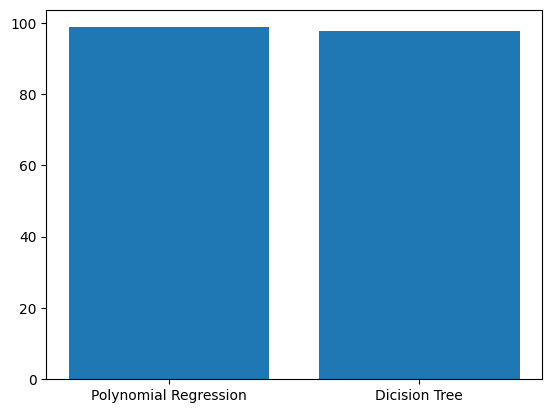

In [ ]:
import matplotlib.pyplot as plt
plt.bar(['Polynomial Regression', 'Dicision Tree'],[98.72, 97.74])

<BarContainer object of 2 artists>

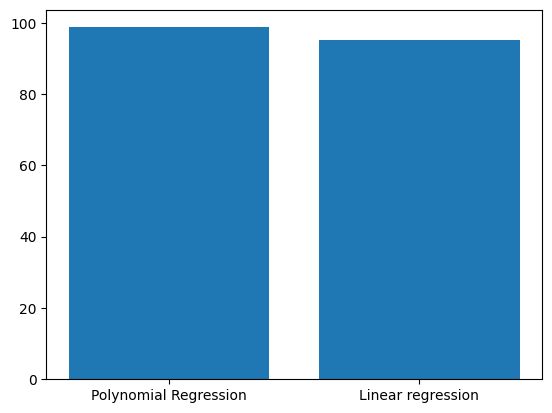

In [ ]:
import matplotlib.pyplot as plt
plt.bar(['Polynomial Regression', 'Linear regression'],[98.72, 95.105])

<BarContainer object of 2 artists>

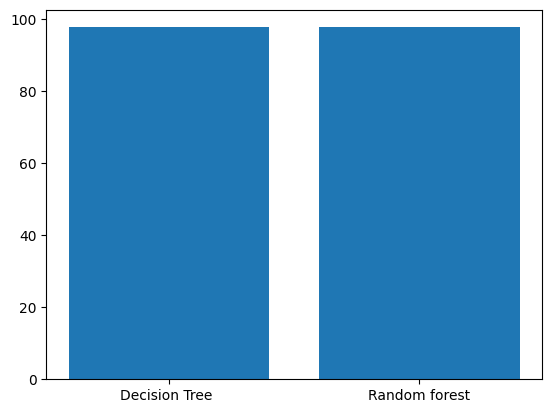

In [ ]:
import matplotlib.pyplot as plt
plt.bar(['Decision Tree ', 'Random forest'],[97.74, 97.74])

<BarContainer object of 2 artists>

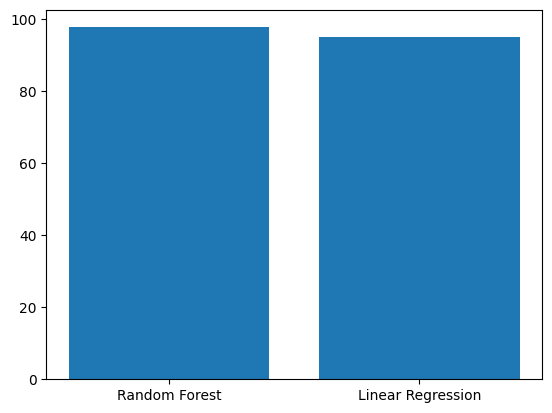

In [ ]:
import matplotlib.pyplot as plt
plt.bar(['Random Forest', 'Linear Regression'],[97.74, 95.105])